In [1]:
# installation
!pip install transformers datasets matplotlib pandas seaborn evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=746435f4c7c08502f8fcd2b226a8ff41d32104aa9f6b5cf66a7b9dff7d59e746
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.1

In [2]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from collections import Counter
from transformers import (
    BertTokenizerFast,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    AlbertForSequenceClassification,AutoTokenizer
)
from google.colab import drive
import os
import json
import evaluate

In [3]:
# google Drive to save models
drive.mount('/content/drive')

# load dataset
dataset = load_dataset("conll2003")

# dataset structure
train_data = dataset["train"]
tag_names = train_data.features["ner_tags"].feature.names

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

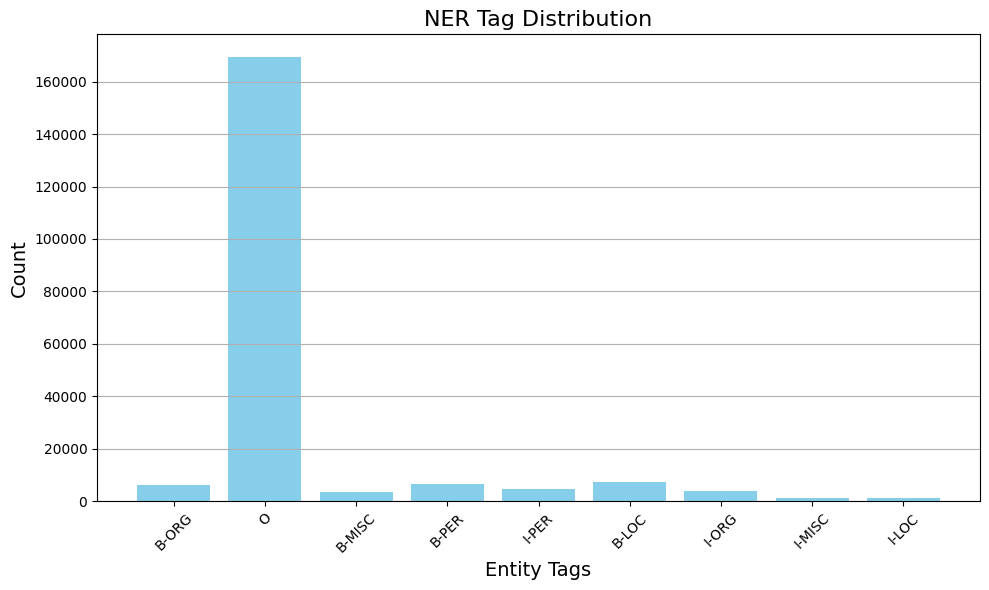

In [4]:
# occurrences of each NER tag in the dataset
ner_tag_counts = Counter(tag_names[tag] for example in train_data for tag in example["ner_tags"])

# plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(ner_tag_counts.keys(), ner_tag_counts.values(), color='skyblue')
plt.xlabel('Entity Tags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('NER Tag Distribution', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [5]:
# tokenization function
def tokenize_and_align_labels(examples, tokenizer, label_all_tokens=True):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True,
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None

        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
# evaluation metric
seqeval = evaluate.load("seqeval")
label_names = dataset["train"].features["ner_tags"].feature.names

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=2)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [7]:
# tokenizer for models
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tinybert_tokenizer = BertTokenizerFast.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
distilbert_tokenizer = BertTokenizerFast.from_pretrained("distilbert-base-uncased")
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")



# tokenize datasets models
tokenized_datasets_bert = dataset.map(lambda x: tokenize_and_align_labels(x, bert_tokenizer), batched=True)
tokenized_datasets_tinybert = dataset.map(lambda x: tokenize_and_align_labels(x, tinybert_tokenizer), batched=True)
tokenized_datasets_distilbert = dataset.map(lambda x: tokenize_and_align_labels(x, distilbert_tokenizer), batched=True)
tokenized_datasets_albert = dataset.map(lambda x: tokenize_and_align_labels(x, albert_tokenizer), batched=True,remove_columns=['id'])

# DataCollator
data_collator_bert = DataCollatorForTokenClassification(bert_tokenizer)
data_collator_tinybert = DataCollatorForTokenClassification(tinybert_tokenizer)
data_collator_distilbert = DataCollatorForTokenClassification(distilbert_tokenizer)
data_collator_albert = DataCollatorForTokenClassification(albert_tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
# BERT model
bert_model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(tag_names)
)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# TinyBERT model
tinybert_model = AutoModelForTokenClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D", num_labels=len(tag_names)
)



pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:

# DistilBERT model
distilbert_model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(tag_names)
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Albert model
albert_model = AutoModelForTokenClassification.from_pretrained(
    "albert-base-v2", num_labels=len(tag_names)
)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# training arguments for BERT
bert_args = TrainingArguments(
    "bert-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# training arguments for TinyBERT
tinybert_args = TrainingArguments(
    "tinybert-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# training arguments for DistilBERT
distilbert_args = TrainingArguments(
    "distilbert-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# training arguments for Albert
albert_args = TrainingArguments(
    "albert-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# trainers
bert_trainer = Trainer(
    bert_model,
    bert_args,
    train_dataset=tokenized_datasets_bert["train"],
    eval_dataset=tokenized_datasets_bert["validation"],
    data_collator=data_collator_bert,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-16-a0569018c795>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


In [17]:
tinybert_trainer = Trainer(
    tinybert_model,
    tinybert_args,
    train_dataset=tokenized_datasets_tinybert["train"],
    eval_dataset=tokenized_datasets_tinybert["validation"],
    data_collator=data_collator_tinybert,
    tokenizer=tinybert_tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-17-169b06e1193d>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tinybert_trainer = Trainer(


In [18]:
distilbert_trainer = Trainer(
    distilbert_model,
    distilbert_args,
    train_dataset=tokenized_datasets_distilbert["train"],
    eval_dataset=tokenized_datasets_distilbert["validation"],
    data_collator=data_collator_distilbert,
    tokenizer=distilbert_tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-18-2875725742de>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distilbert_trainer = Trainer(


In [ ]:
albert_trainer = Trainer(
    albert_model,
    albert_args,
    train_dataset=tokenized_datasets_albert["train"],
    eval_dataset=tokenized_datasets_albert["validation"],
    data_collator=data_collator_albert,
    tokenizer=albert_tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-19-7abb22936770>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  albert_trainer = Trainer(


In [19]:
# train BERT
print("Training BERT...")
bert_trainer.train()



wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training BERT...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.218600,0.061752,0.917586,0.930417,0.923957,0.983240
2,0.046100,0.059269,0.926424,0.940933,0.933622,0.984574
3,0.026600,0.056690,0.934497,0.946415,0.940418,0.986084


TrainOutput(global_step=2634, training_loss=0.07605450861184274, metrics={'train_runtime': 531.2693, 'train_samples_per_second': 79.287, 'train_steps_per_second': 4.958, 'total_flos': 1020143109346326.0, 'train_loss': 0.07605450861184274, 'epoch': 3.0})

In [ ]:
# train TinyBERT
print("Training TinyBERT...")
tinybert_trainer.train()



Training TinyBERT...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.517500,0.222734,0.736870,0.773800,0.754884,0.947623
2,0.209000,0.167778,0.791154,0.812395,0.801634,0.957472
3,0.165800,0.154173,0.810345,0.836000,0.822972,0.961126


TrainOutput(global_step=2634, training_loss=0.2636397520339027, metrics={'train_runtime': 68.5826, 'train_samples_per_second': 614.194, 'train_steps_per_second': 38.406, 'total_flos': 54833231758662.0, 'train_loss': 0.2636397520339027, 'epoch': 3.0})

In [ ]:
# train DistilBert
print("Training DistilBert...")
distilbert_trainer.train()


Training DistilBert...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.249700,0.070348,0.898823,0.922251,0.910386,0.979888
2,0.050600,0.059345,0.923026,0.935004,0.928976,0.983002
3,0.030400,0.059849,0.926913,0.937801,0.932325,0.983875


TrainOutput(global_step=2634, training_loss=0.08640721410897616, metrics={'train_runtime': 261.8113, 'train_samples_per_second': 160.891, 'train_steps_per_second': 10.061, 'total_flos': 510122266253334.0, 'train_loss': 0.08640721410897616, 'epoch': 3.0})

In [ ]:

# train Albert
print("Training Albert...")
albert_trainer.train()

Training Albert...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.166600,0.090661,0.877965,0.873222,0.875587,0.974739
2,0.053000,0.066346,0.924281,0.931209,0.927732,0.984082
3,0.027700,0.063710,0.928080,0.936060,0.932053,0.985048


TrainOutput(global_step=2634, training_loss=0.0699164667361237, metrics={'train_runtime': 450.3948, 'train_samples_per_second': 93.525, 'train_steps_per_second': 5.848, 'total_flos': 95180897043012.0, 'train_loss': 0.0699164667361237, 'epoch': 3.0})

In [ ]:
# save models to Google Drive
bert_drive_path = "/content/drive/My Drive/NER_Models/bert_model"
tinybert_drive_path = "/content/drive/My Drive/NER_Models/tinybert_model"
distilbert_drive_path = "/content/drive/My Drive/NER_Models/distilbert_model"
albert_drive_path = "/content/drive/My Drive/NER_Models/albert_model"

os.makedirs(bert_drive_path, exist_ok=True)
os.makedirs(tinybert_drive_path, exist_ok=True)
os.makedirs(distilbert_drive_path, exist_ok=True)
os.makedirs(albert_drive_path, exist_ok=True)

# save BERT model
bert_model.save_pretrained(bert_drive_path)
bert_tokenizer.save_pretrained(bert_drive_path)



('/content/drive/My Drive/NER_Models/bert_model/tokenizer_config.json',
 '/content/drive/My Drive/NER_Models/bert_model/special_tokens_map.json',
 '/content/drive/My Drive/NER_Models/bert_model/vocab.txt',
 '/content/drive/My Drive/NER_Models/bert_model/added_tokens.json',
 '/content/drive/My Drive/NER_Models/bert_model/tokenizer.json')

In [ ]:
# save TinyBERT model
tinybert_model.save_pretrained(tinybert_drive_path)
tinybert_tokenizer.save_pretrained(tinybert_drive_path)


('/content/drive/My Drive/NER_Models/tinybert_model/tokenizer_config.json',
 '/content/drive/My Drive/NER_Models/tinybert_model/special_tokens_map.json',
 '/content/drive/My Drive/NER_Models/tinybert_model/vocab.txt',
 '/content/drive/My Drive/NER_Models/tinybert_model/added_tokens.json',
 '/content/drive/My Drive/NER_Models/tinybert_model/tokenizer.json')

In [ ]:
# save DistilBERT model
distilbert_model.save_pretrained(distilbert_drive_path)
distilbert_tokenizer.save_pretrained(distilbert_drive_path)

('/content/drive/My Drive/NER_Models/distilbert_model/tokenizer_config.json',
 '/content/drive/My Drive/NER_Models/distilbert_model/special_tokens_map.json',
 '/content/drive/My Drive/NER_Models/distilbert_model/vocab.txt',
 '/content/drive/My Drive/NER_Models/distilbert_model/added_tokens.json',
 '/content/drive/My Drive/NER_Models/distilbert_model/tokenizer.json')

In [ ]:
# save Albert model
albert_model.save_pretrained(albert_drive_path)
albert_tokenizer.save_pretrained(albert_drive_path)

('/content/drive/My Drive/NER_Models/albert_model/tokenizer_config.json',
 '/content/drive/My Drive/NER_Models/albert_model/special_tokens_map.json',
 '/content/drive/My Drive/NER_Models/albert_model/spiece.model',
 '/content/drive/My Drive/NER_Models/albert_model/added_tokens.json',
 '/content/drive/My Drive/NER_Models/albert_model/tokenizer.json')

In [ ]:
print("Models successfully saved to Google Drive!")

Models successfully saved to Google Drive!


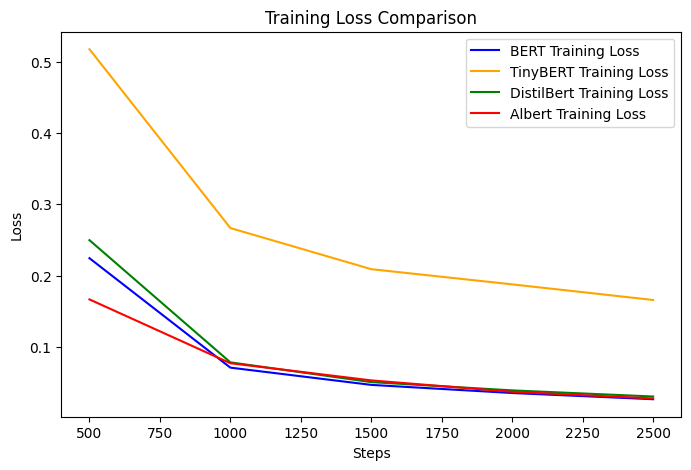

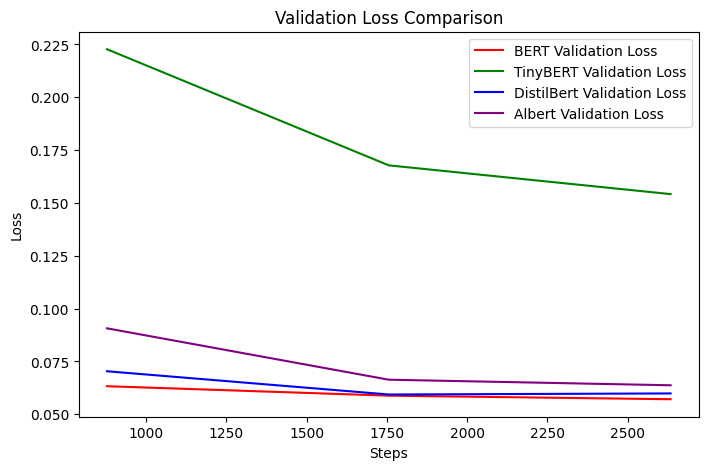

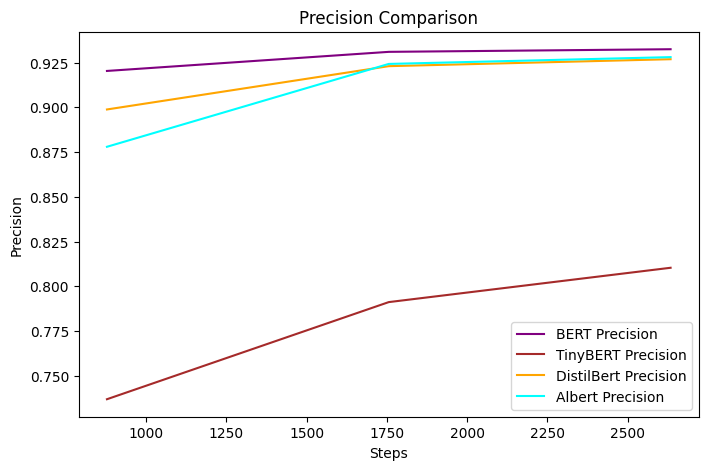

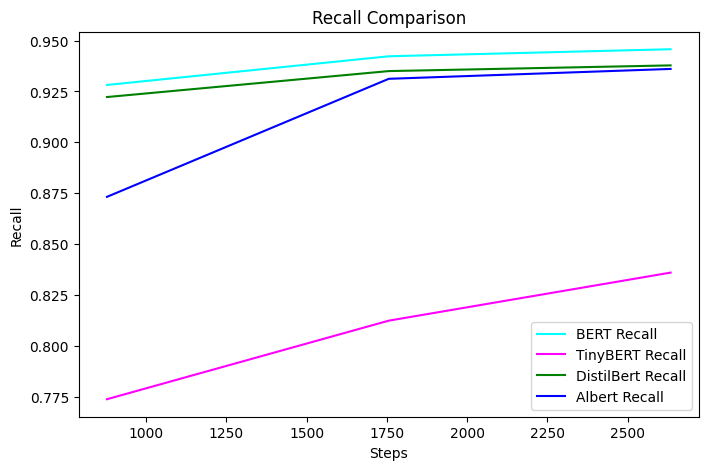

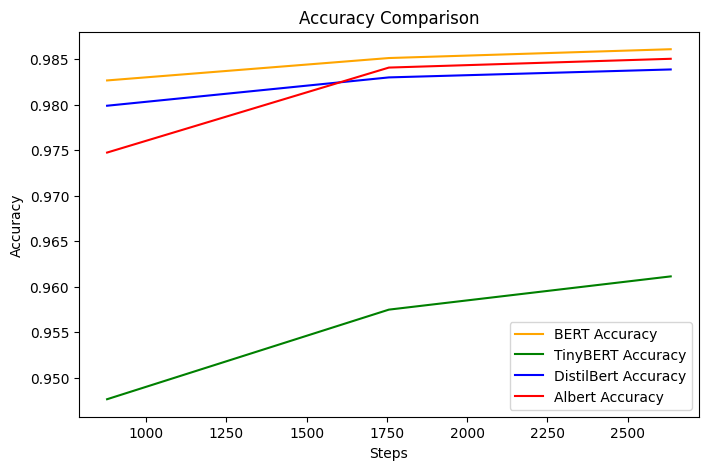

In [ ]:
import matplotlib.pyplot as plt

# function to extract metrics from logs

def extract_metrics(trainer_logs):
    """
    Extract metrics (loss, eval_loss, precision, recall, accuracy) from trainer logs.

    Args:
        trainer_logs (list): Logs from the trainer state.

    Returns:
        dict: Dictionary containing metrics and their corresponding steps.
    """
    metrics = {
        "train_loss": [log["loss"] for log in trainer_logs if "loss" in log],
        "train_steps": [log["step"] for log in trainer_logs if "loss" in log],
        "eval_loss": [log["eval_loss"] for log in trainer_logs if "eval_loss" in log],
        "eval_steps": [log["step"] for log in trainer_logs if "eval_loss" in log],
        "precision": [log["eval_precision"] for log in trainer_logs if "eval_precision" in log],
        "precision_steps": [log["step"] for log in trainer_logs if "eval_precision" in log],
        "recall": [log["eval_recall"] for log in trainer_logs if "eval_recall" in log],
        "recall_steps": [log["step"] for log in trainer_logs if "eval_recall" in log],
        "accuracy": [log["eval_accuracy"] for log in trainer_logs if "eval_accuracy" in log],
        "accuracy_steps": [log["step"] for log in trainer_logs if "eval_accuracy" in log],
    }
    return metrics

# function to plot comparison graphs
def plot_comparison(metrics_1, metrics_2, metrics_3, metrics_4, model_1_name, model_2_name, model_3_name, model_4_name):
    """
    Plots comparison graphs for Training Loss, Validation Loss, Precision, Recall, and Accuracy.

    Args:
        metrics_1 (dict): Metrics for model 1.
        metrics_2 (dict): Metrics for model 2.
        model_1_name (str): Name of model 1.
        model_2_name (str): Name of model 2.
    """

    # Training Loss Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_1["train_steps"], metrics_1["train_loss"], label=f"{model_1_name} Training Loss", color="blue")
    plt.plot(metrics_2["train_steps"], metrics_2["train_loss"], label=f"{model_2_name} Training Loss", color="orange")
    plt.plot(metrics_3["train_steps"], metrics_3["train_loss"], label=f"{model_3_name} Training Loss", color="green")
    plt.plot(metrics_4["train_steps"], metrics_4["train_loss"], label=f"{model_4_name} Training Loss", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

    # Validation Loss Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_1["eval_steps"], metrics_1["eval_loss"], label=f"{model_1_name} Validation Loss", color="red")
    plt.plot(metrics_2["eval_steps"], metrics_2["eval_loss"], label=f"{model_2_name} Validation Loss", color="green")
    plt.plot(metrics_3["eval_steps"], metrics_3["eval_loss"], label=f"{model_3_name} Validation Loss", color="blue")
    plt.plot(metrics_4["eval_steps"], metrics_4["eval_loss"], label=f"{model_4_name} Validation Loss", color="purple")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.show()

    # Precision Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_1["precision_steps"], metrics_1["precision"], label=f"{model_1_name} Precision", color="purple")
    plt.plot(metrics_2["precision_steps"], metrics_2["precision"], label=f"{model_2_name} Precision", color="brown")
    plt.plot(metrics_3["precision_steps"], metrics_3["precision"], label=f"{model_3_name} Precision", color="orange")
    plt.plot(metrics_4["precision_steps"], metrics_4["precision"], label=f"{model_4_name} Precision", color="cyan")
    plt.xlabel("Steps")
    plt.ylabel("Precision")
    plt.title("Precision Comparison")
    plt.legend()
    plt.show()

    # Recall Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_1["recall_steps"], metrics_1["recall"], label=f"{model_1_name} Recall", color="cyan")
    plt.plot(metrics_2["recall_steps"], metrics_2["recall"], label=f"{model_2_name} Recall", color="magenta")
    plt.plot(metrics_3["recall_steps"], metrics_3["recall"], label=f"{model_3_name} Recall", color="green")
    plt.plot(metrics_4["recall_steps"], metrics_4["recall"], label=f"{model_4_name} Recall", color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Recall")
    plt.title("Recall Comparison")
    plt.legend()
    plt.show()

    # Accuracy Comparison
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_1["accuracy_steps"], metrics_1["accuracy"], label=f"{model_1_name} Accuracy", color="orange")
    plt.plot(metrics_2["accuracy_steps"], metrics_2["accuracy"], label=f"{model_2_name} Accuracy", color="green")
    plt.plot(metrics_3["accuracy_steps"], metrics_3["accuracy"], label=f"{model_3_name} Accuracy", color="blue")
    plt.plot(metrics_4["accuracy_steps"], metrics_4["accuracy"], label=f"{model_4_name} Accuracy", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.show()


# Extract Metrics for BERT
bert_logs = bert_trainer.state.log_history
bert_metrics = extract_metrics(bert_logs)

# Extract Metrics for TinyBERT
tinybert_logs = tinybert_trainer.state.log_history
tinybert_metrics = extract_metrics(tinybert_logs)

# Extract Metrics for DistilBert
distilbert_logs = distilbert_trainer.state.log_history
distilbert_metrics = extract_metrics(distilbert_logs)

# Extract Metrics for Albert
albert_logs = albert_trainer.state.log_history
albert_metrics = extract_metrics(albert_logs)

# Plot Comparison Graphs
plot_comparison(bert_metrics, tinybert_metrics, distilbert_metrics, albert_metrics, "BERT", "TinyBERT", "DistilBert","Albert")
